# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [11]:
import math

import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import spacy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

from tqdm.auto import tqdm

lemmatizer = WordNetLemmatizer()

import warnings
warnings.simplefilter('ignore')

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [13]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [14]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [15]:
df_reviews.shape

(47331, 17)

In [16]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [17]:
df_reviews.dropna(inplace=True)

In [18]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [19]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

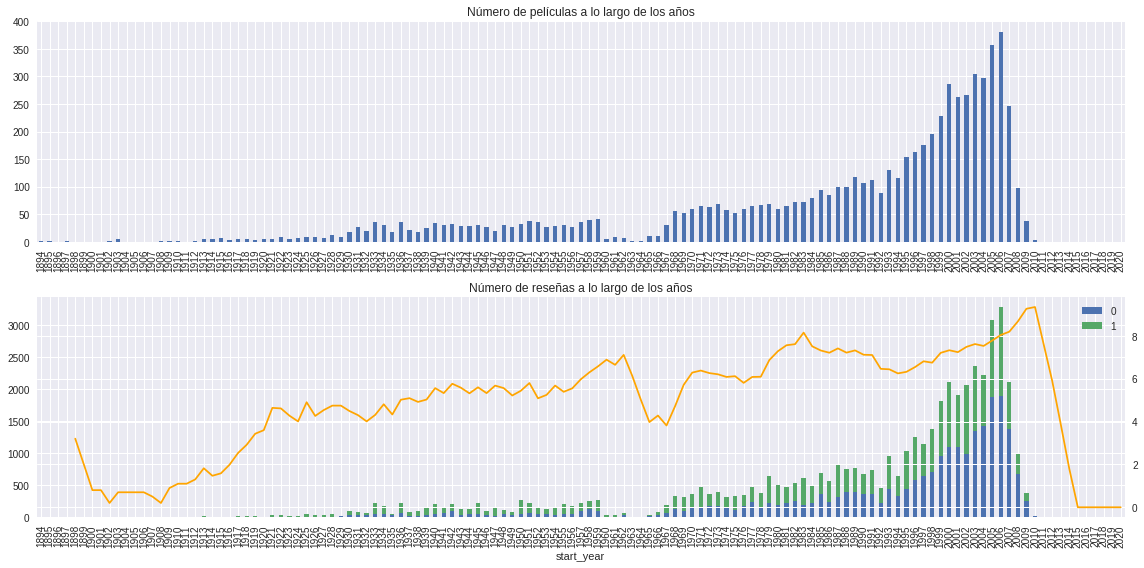

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')
ax.legend()

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

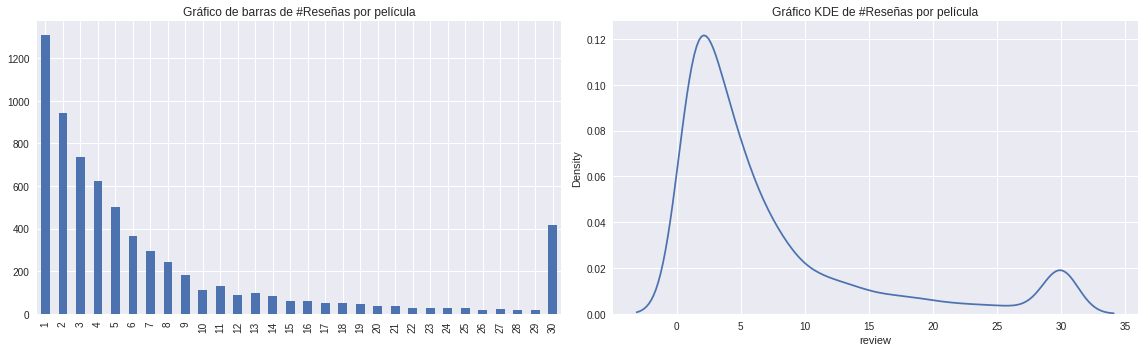

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [22]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

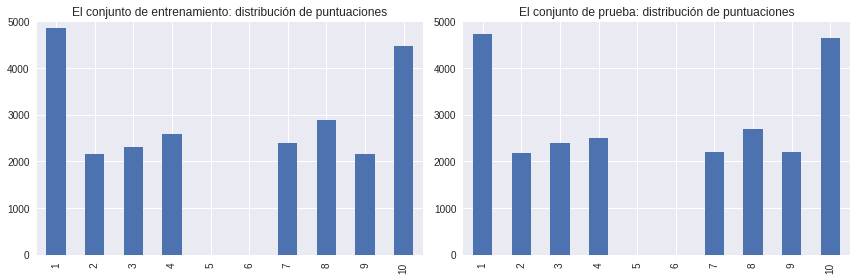

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

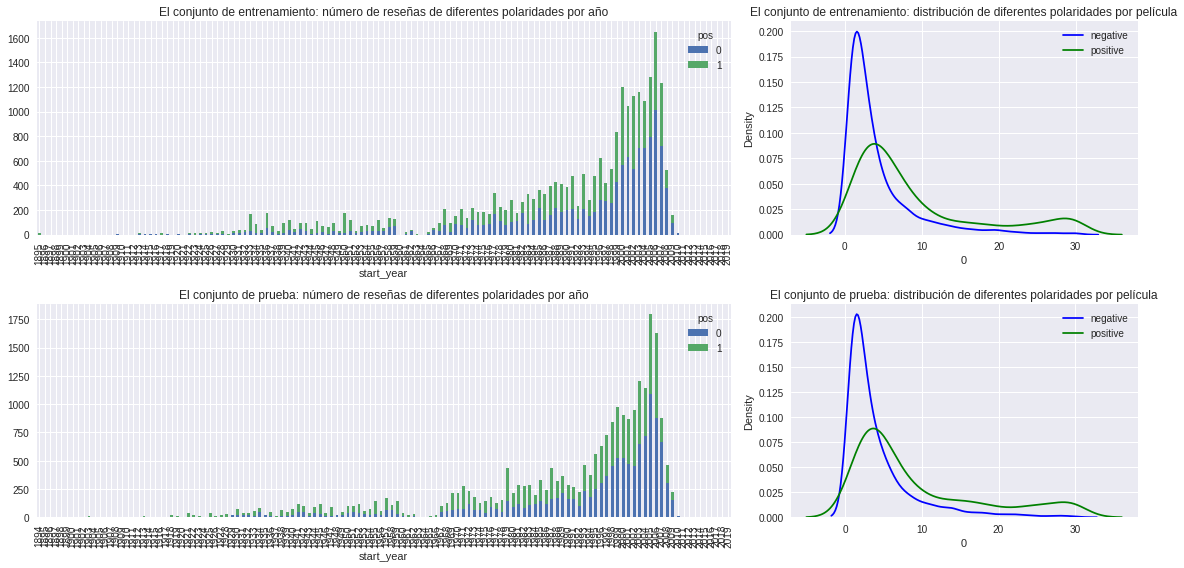

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [25]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [26]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub('[^a-zA-Z\']', ' ', x)).str.lower()
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i 'm totally agree with garryjohal from singap...
Name: review_norm, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [27]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [28]:
stop = set(stopwords.words('english'))

In [29]:
f_train0 = []
f_test0 = []

for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_train0.append(l_join)

for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_test0.append(l_join)

model = DummyClassifier().fit(f_train0, train_target)

           train  test
Exactitud    0.5   0.5
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


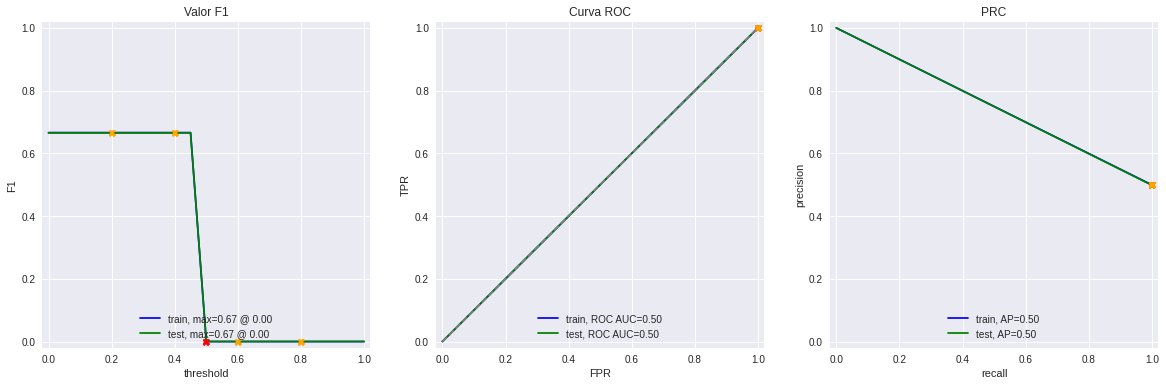

In [30]:
evaluate_model(model, f_train0, train_target, f_test0, test_target)

El modelo constante nos da un valor F1 de 0.5, los demás modelos debemos obtener algo más alto que este valor.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [31]:
corpus_train = []
corpus_test =[]

Se crea el data set de entrenamiento

In [32]:
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corpus_train.append(l_join)

Se crea el data set de prueba

In [33]:
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corpus_test.append(l_join)

In [34]:
count_tf_idf1 = TfidfVectorizer(stop_words = stopwords.words('english'), 
                                lowercase=True, 
                                ngram_range=(1,1))
train_features_1 = count_tf_idf1.fit_transform(corpus_train)
test_features_1 = count_tf_idf1.transform(corpus_test)

In [35]:
model_1 = LogisticRegression().fit(train_features_1, train_target)

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


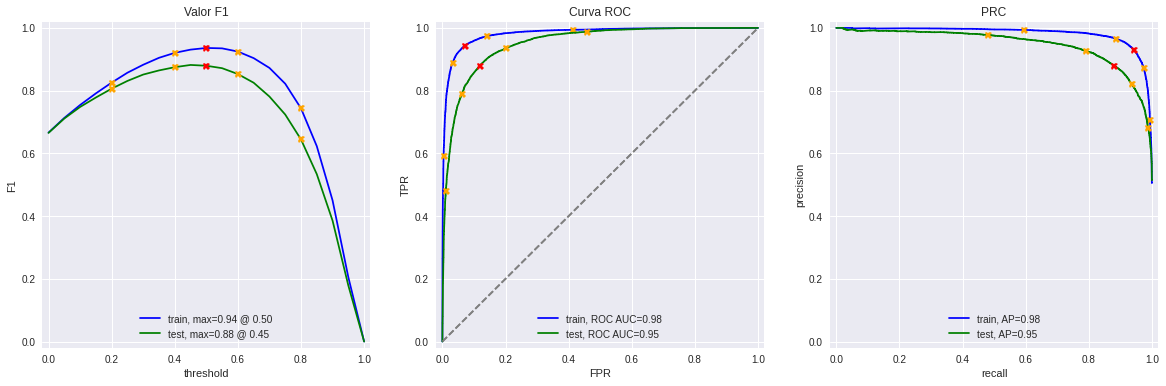

In [36]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

El modelo nos arroja un valor F1 de 0.88, este es mucho mejor que el modelo dummy.

### Modelo 3 - spaCy, TF-IDF y LR

In [37]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [39]:
corpus_train3 = []
corpus_test3 = []

In [40]:
for text in df_reviews_train['review_norm']:
    result = text_preprocessing_3(text)
    corpus_train3.append(result)

In [41]:
for text in df_reviews_test['review_norm']:
    result = text_preprocessing_3(text)
    corpus_test3.append(result)

In [42]:
count_tf_idf3 = TfidfVectorizer(stop_words =stopwords.words('english'),
                               lowercase=True,
                               ngram_range=(1,1))
f_train3 = count_tf_idf3.fit_transform(corpus_train3)
f_test3 = count_tf_idf3.transform(corpus_test3)

In [43]:
model_3 = LogisticRegression().fit(f_train3, train_target)

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


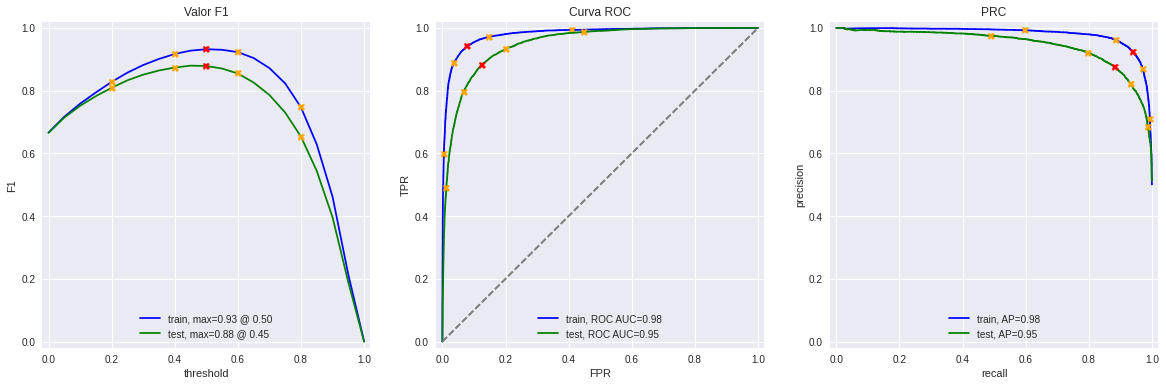

In [44]:
evaluate_model(model_3, f_train3, train_target, f_test3, test_target)

Los valores de las métricas de este modelo bajaron en comparación con el anterior.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [45]:
model = LGBMClassifier()
parameter = {'num_leaves':[10,30],
            'learning_rate':[0.1, 0.5],
            'n_estimators':[10,20],
            'random_state':[12345]}

grid = GridSearchCV(model, parameter, scoring='f1',cv=3)
grid.fit(f_train3, train_target)
best_param = grid.best_params_

In [46]:
print('Mejor F1:',grid.best_score_)
print('Parametros:',best_param)

Mejor F1: 0.8353556903550704
Parametros: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}


In [47]:
model_4 = LGBMClassifier(num_leaves=best_param['num_leaves'],
                        learning_rate=best_param['learning_rate'],
                        n_estimators=best_param['n_estimators'],
                        random_state=best_param['random_state'])
model_4.fit(f_train3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=30,
               random_state=12345)

           train  test
Exactitud   0.90  0.85
F1          0.90  0.85
APS         0.96  0.92
ROC AUC     0.96  0.92


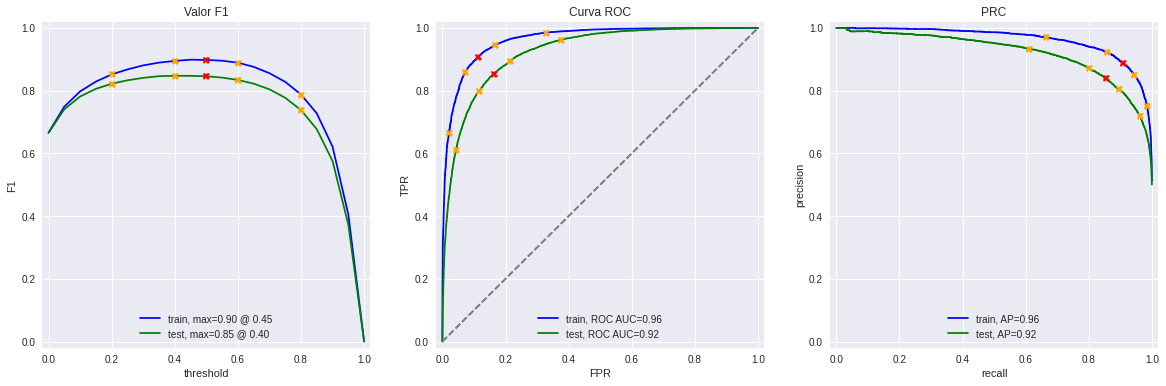

In [48]:
evaluate_model(model_4, f_train3, train_target, f_test3, test_target)

Con el gradiente el valor F1 es menor al modelo 1 con regresión logística

## Mis reseñas

In [49]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub('[^a-zA-Z\']', ' ', x)).str.lower()
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i did n't expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Las reseñas 0, 1, 3, 6 son negativas mientras que las reseñas 2,4 y 5 son positivos.

### Modelo 2

In [50]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i did n't expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it 's a decent flick i could see mys
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Las reseñas 0, 1, 3 y 6 nos dan valores cercanos a 0, es decir son reseñas negativas por lo que el modelo funciona acertadamente.

### Modelo 3

In [51]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i did n't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it 's a decent flick i could see mys
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Las reseñas 0, 1, 3, y 6 nos dan valores cercanos a 0, sobretodo la número 6, en cuanto a los positivos la reseña 2 es menor a la mitad por lo que el modelo no es preciso y tiende a errores en algunas reseñas.

### Modelo 4

In [52]:
texts = my_reviews['review_norm']

count_tf_idf4 = count_tf_idf3
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.32:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.24:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.67:  i did n't expect the reboot to be so good writers really cared about the source material
0.78:  the movie had its upsides and downsides but i feel like overall it 's a decent flick i could see mys
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Este modelo es el que muestra los datos más cercanos al valor de 0.5, es decir a los valores neutrales se podría decir, de los modelos probados es el peor y no hay certidumbre sobre la correcta predicción del sentimiento de la reseña.

## Conclusiones

En este proyecto se trabajo con la clasificación de `reviews` sobre una empresa, es decir el sentimiento de los usuarios, se hicieron 4 trabajos de modelado para dar un valor númerico y saber por medio de una calificación que tan bueno es un servicio o si es necesarios cambiarlo.

Con el modelo usando NLTK encontramos los valores más precisos para las valoraciones de los usuarios y es el modelo que podemos usar para dar certeza a la empresa `Film Junky Union` el cual nos dio un valor F1 de 0.88.